In [1]:
import netCDF4
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal
import statistics as stats
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import skimage as ski
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import font_manager
from scipy.ndimage import label, binary_dilation, generate_binary_structure, filters, iterate_structure, binary_fill_holes, binary_erosion
from collections import deque
mpl.rcParams['font.family'] = 'Roboto' # For Cumulus
# mpl.rcParams['font.family'] = 'Arial' # For M1 MBP 
import holoviews as hv
from colorcet.plotting import swatch, swatches, candy_buttons
%pylab inline
from IPython.display import display, HTML
import xarray as xr
# import hvplot
import pint_xarray
import hvplot.xarray
from matplotlib.collections import LineCollection
from datetime import datetime, timedelta
import colorcet
import matplotlib.image as mpimg
import itertools
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def label_perimeter(tracknumber, dilationstructure):
    """
    Labels the perimeter on a 2D map from object tracknumber masks.
    """
    # Get unique tracknumbers that is no nan
    tracknumber_unique = np.unique(tracknumber[~np.isnan(tracknumber)]).astype(np.int32)

    # Make an array to store the perimeter
    tracknumber_perim = np.zeros(tracknumber.shape, dtype=np.int32)

    # Loop over each tracknumbers
    for ii in tracknumber_unique:
        # Isolate the cell mask
        itn = tracknumber == ii
        # Erode the cell by 1 pixel
        itn_erode = binary_erosion(itn, structure=dilationstructure).astype(itn.dtype)
        # Subtract the eroded area to get the perimeter
        iperim = np.logical_xor(itn, itn_erode)
        # Label the perimeter pixels with the track number
        tracknumber_perim[iperim == 1] = ii

    return tracknumber_perim

In [3]:
def sort_renumber(
    labelcell_number2d,
    min_cellpix,
):
    """
    Sorts 2D labeled cells by size, and removes cells smaller than min_cellpix.
    Args:
        labelcell_number2d: np.ndarray()
            Labeled cell number array in 2D.
        min_cellpix: float
            Minimum number of pixel to count as a cell.
    Returns:
        sortedlabelcell_number2d: np.ndarray(int)
            Sorted labeled cell number array in 2D.
        sortedcell_npix: np.ndarray(int)
            Number of pixels for each labeled cell in 1D.
    """

    # Create output arrays
    sortedlabelcell_number2d = np.zeros(np.shape(labelcell_number2d), dtype=int)

    # Get number of labeled cells
    nlabelcells = np.nanmax(labelcell_number2d)

    # Check if there is any cells identified
    if nlabelcells > 0:

        labelcell_npix = np.full(nlabelcells, -999, dtype=int)
        # Loop over each labeled cell
        for ilabelcell in range(1, nlabelcells + 1):
            # Count number of pixels for the cell
            ilabelcell_npix = np.count_nonzero(labelcell_number2d == ilabelcell)
            # Check if cell satisfies size threshold
            if ilabelcell_npix > min_cellpix:
                labelcell_npix[ilabelcell - 1] = ilabelcell_npix

        # # This faster approach does not work
        # # Because when labelcell_number2d is not sequentially numbered (e.g., when some cells are removed)
        # # This approach does not get the same sequence with the above one
        # # Count number of pixels for each unique cells
        # cellnum, labelcell_npix = np.unique(labelcell_number2d, return_counts=True)
        # # Remove background and cells below size threshold
        # labelcell_npix = labelcell_npix[(cellnum > 0)]
        # labelcell_npix[(labelcell_npix <= min_cellpix)] = -999

        # Check if any of the cells passes the size threshold test
        ivalidcells = np.where(labelcell_npix > 0)[0]
        # ivalidcells = np.array(np.where(labelcell_npix > 0))[0, :]
        ncells = len(ivalidcells)

        if ncells > 0:
            # Isolate cells that satisfy size threshold
            # Add one since label numbers start at 1 and indices, which validcells reports starts at 0
            labelcell_number1d = np.copy(ivalidcells) + 1
            labelcell_npix = labelcell_npix[ivalidcells]

            # Sort cells from largest to smallest and get the sorted index
            order = np.argsort(labelcell_npix)[::-1]
            # order = order[::-1]  # Reverses the order

            # Sort the cells by size
            sortedcell_npix = np.copy(labelcell_npix[order])
            sortedcell_number1d = np.copy(labelcell_number1d[order])

            # Loop over the 2D cell number to re-number them by size
            cellstep = 0
            for icell in range(0, ncells):
                # Find 2D indices that match the cell number
                sortedcell_indices = np.where(
                    labelcell_number2d == sortedcell_number1d[icell]
                )
                # Get one of the dimensions from the 2D indices to count the size
                #             nsortedcellindices = np.shape(sortedcell_indices)[1]
                nsortedcellindices = len(sortedcell_indices[1])
                # Check if the size matches the sorted cell size
                if nsortedcellindices == sortedcell_npix[icell]:
                    # Renumber the cell in 2D
                    cellstep += 1
                    sortedlabelcell_number2d[sortedcell_indices] = np.copy(cellstep)

        else:
            # Return an empty array
            sortedcell_npix = np.zeros(0)
    else:
        # Return an empty array
        sortedcell_npix = np.zeros(0)

    return (
        sortedlabelcell_number2d,
        sortedcell_npix,
    )

In [4]:
# the if statement is how the code will handle the case where there is no "core"
# the ncorepix variable is defined before this function is called
# flipped less-than to greater-than, added new variables for the two conditions for a cloud
def find_and_label_cold_cores(ncorepix, nx, ny, smoothir_1, smoothir_2, thresh_core_1, thresh_core_2):
    #################################################################
    # Find cold cores in smoothed data
    smoothcore_flag = np.zeros((ny, nx),dtype=int)
    smoothcore_indices = np.where((smoothir_1 >= thresh_core_1) & (smoothir_2 >= thresh_core_2))
    nsmoothcorepix = np.shape(smoothcore_indices)[1]
    if ncorepix > 0:
        smoothcore_flag[smoothcore_indices] = 1
    ##############################################################
    # Label cold cores in smoothed data
    labelcore_number2d, nlabelcores = label(smoothcore_flag)
    return labelcore_number2d, 

In [7]:
# CSAPR

In [78]:
# csapr = '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1//celltracking/20181015.0000_20190303.0000/celltracks_20181129_1500.nc',\
#         '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1//celltracking/20181015.0000_20190303.0000/celltracks_20181129_1700.nc'
# csapr = '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1//celltracking/20181015.0000_20190303.0000/celltracks_20181204_1530.nc',\
#         '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1//celltracking/20181015.0000_20190303.0000/celltracks_20181204_1630.nc'
csapr = '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1//celltracking/20181015.0000_20190303.0000/celltracks_20190123_1415.nc',\
        '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1//celltracking/20181015.0000_20190303.0000/celltracks_20190123_1615.nc'
# csapr = '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1//celltracking/20181015.0000_20190303.0000/celltracks_20190129_1630.nc',\
#         '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1//celltracking/20181015.0000_20190303.0000/celltracks_20190129_1730.nc'
d_csapr = xr.open_mfdataset(csapr,combine='nested',concat_dim='time')

/ccsopen/home/enochjo/miniconda3/envs/flextrkr/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [79]:
lon_sub_csapr = d_csapr['longitude'].data[0,:,:].squeeze()
lat_sub_csapr = d_csapr['latitude'].data[0,:,:].squeeze()
echotop10_csapr = d_csapr['echotop10'].load().squeeze() 
convmask_sub_csapr = d_csapr['conv_core'].load().squeeze() 
tracknumber_sub_csapr = d_csapr['tracknumber'].load().squeeze()* d_csapr['conv_core'].load().squeeze() 

In [80]:
# LASSO

In [81]:
# lasso = '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20181129/gefs09/base/les/tracks//celltracking/20181129.1300_20181129.1800/celltracks_20181129_150000.nc',\
#         '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20181129/gefs09/base/les/tracks//celltracking/20181129.1300_20181129.1800/celltracks_20181129_170000.nc'
# lasso = '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20181204/gefs18/base/les/tracks//celltracking/20181204.1500_20181204.1900/celltracks_20181204_153000.nc',\
#         '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20181204/gefs18/base/les/tracks//celltracking/20181204.1500_20181204.1900/celltracks_20181204_163000.nc'
lasso = '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20190123/gefs18/base/les/tracks//celltracking/20190123.1400_20190123.1800/celltracks_20190123_141500.nc',\
        '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20190123/gefs18/base/les/tracks//celltracking/20190123.1400_20190123.1800/celltracks_20190123_161500.nc'
# lasso = '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20190129/eda09/base/les/tracks//celltracking/20190129.1500_20190129.1800/celltracks_20190129_163000.nc',\
#         '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20190129/eda09/base/les/tracks//celltracking/20190129.1500_20190129.1800/celltracks_20190129_173000.nc'
d_lasso = xr.open_mfdataset(lasso,combine='nested',concat_dim='time')

/ccsopen/home/enochjo/miniconda3/envs/flextrkr/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [82]:
lon_sub = d_lasso['longitude'].data[0,:,:].squeeze()
lat_sub = d_lasso['latitude'].data[0,:,:].squeeze()
echotop10 = d_lasso['echotop10'].load().squeeze()/1000 #EJ
convmask_sub = d_lasso['conv_core'].load().squeeze() #EJ
tracknumber_sub = d_lasso['tracknumber'].load().squeeze()* d_lasso['conv_core'].load().squeeze() #EJ

In [10]:
dst = xr.open_dataset('/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20181129/gefs09/base/les/out_d4/wrfout_d02_2018-11-29_17_58_15')
hgt = dst['HGT'].data.squeeze()/1000
hgt = hgt[::5,::5]

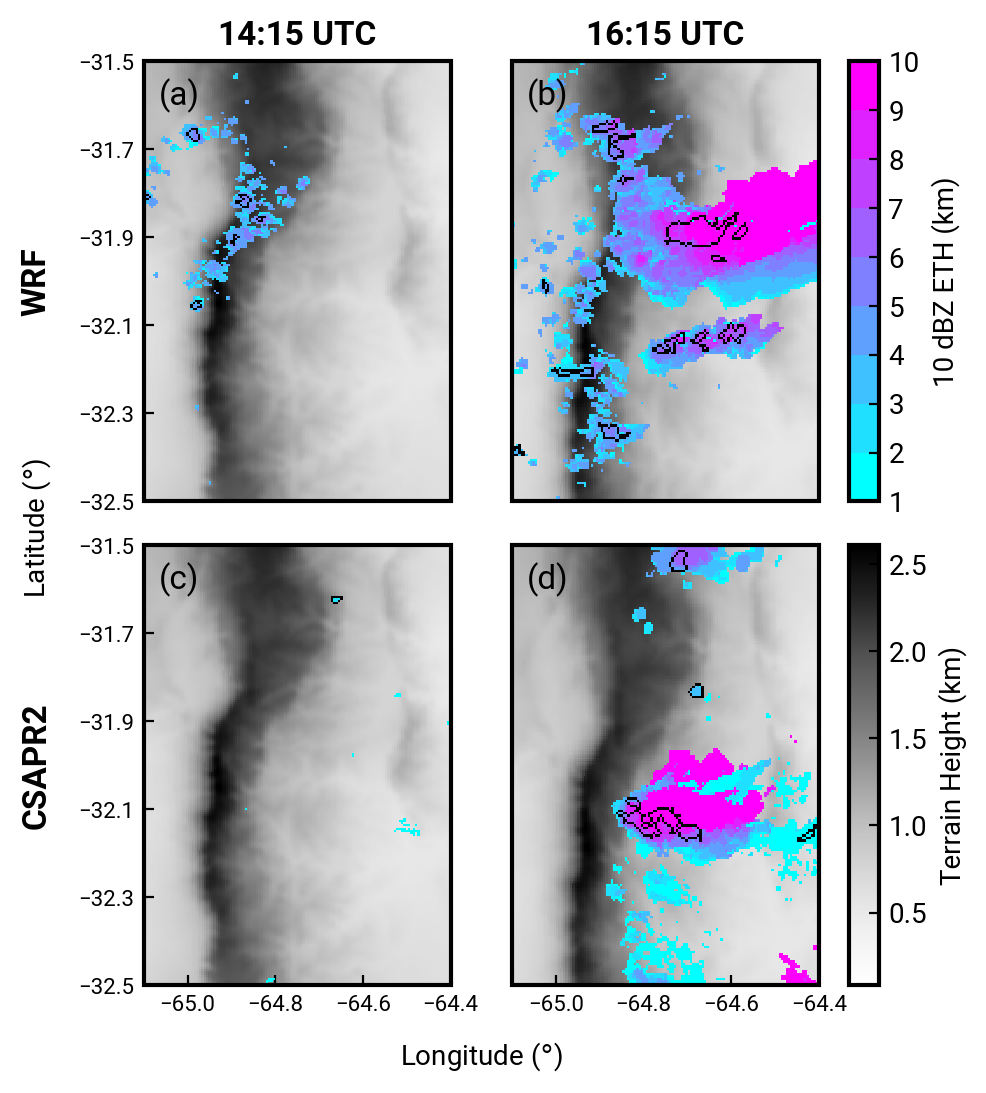

In [87]:
# Set up map projection
proj = ccrs.PlateCarree()

# Set up figure
fig, axs = plt.subplots(2, 2, figsize=(5, 6), subplot_kw={'projection': proj})
axs = axs.ravel()
cmap = plt.get_cmap('cool')
levels = np.arange(1,11,1)
norm_ref = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
dilationstructure = generate_binary_structure(2,1)

# map_extent = [-65.1, -64.4, -32.6+0.8, -31.8+0.8] # For 20181204
map_extent = [-65.1, -64.4, -32.6+0.3, -31.8+0.3] # For 20190123
# map_extent = [-65.1, -64.4, -32.6, -31.8]
for c in np.arange(0,2):
    cft = axs[c].pcolormesh(lon_sub, lat_sub, hgt, cmap='Greys',transform=proj, zorder=0) # EJ
    cf1 = axs[c].pcolormesh(lon_sub, lat_sub, echotop10[c,:,:],norm=norm_ref, cmap=cmap, transform=proj, zorder=2) # EJ
    tn_perim = label_perimeter(convmask_sub.data[c,:,:], dilationstructure)
    Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
    Tn[Tn > 0] = 10
    tn1 = axs[c].pcolormesh(lon_sub, lat_sub, Tn, cmap='gray', transform=proj, zorder=3)

c = 2
for i in np.arange(0,2):
    cft = axs[c].pcolormesh(lon_sub, lat_sub, hgt, cmap='Greys',transform=proj, zorder=0) # EJ
    cf1 = axs[c].pcolormesh(lon_sub_csapr, lat_sub_csapr, echotop10_csapr[i,:,:],norm=norm_ref, cmap=cmap, transform=proj, zorder=2) # EJ
    tn_perim = label_perimeter(convmask_sub_csapr.data[i,:,:], dilationstructure)
    Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
    Tn[Tn > 0] = 10
    tn1 = axs[c].pcolormesh(lon_sub_csapr, lat_sub_csapr, Tn, cmap='gray', transform=proj, zorder=3)    
    c = c+1

alp = ['(a)','(b)','(c)','(d)','(e)','(f)']
for c in np.arange(0,4):
    axs[c].text(0.05,0.9,alp[c],transform=axs[c].transAxes,fontsize=12)
    axs[c].tick_params(direction='in')
    axs[c].set_extent(map_extent, crs=proj)
    axs[c].set_aspect('auto', adjustable=None)
    axs[c].tick_params(axis='both', which='major', labelsize=8)
    for spine in axs[c].spines.values():
        spine.set_linewidth(1.5)

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.1)
fig.subplots_adjust(right=0.8)

p1 = axs[1].get_position().y0
h1 = axs[1].get_position().y1-p1
cbar_ax = fig.add_axes([0.83, p1, 0.03, h1])
cbar2 = fig.colorbar(cf1, cax=cbar_ax, label='10 dBZ ETH (km)', ticks=levels)
cbar2.outline.set_linewidth(1.5) 
cbar2.ax.tick_params(direction='in')

p2 = axs[3].get_position().y0
h2 = axs[3].get_position().y1-p2
cbar_ax = fig.add_axes([0.83, p2, 0.03, h2])
cbar1 = fig.colorbar(cft, cax=cbar_ax, label='Terrain Height (km)')
cbar1.outline.set_linewidth(1.5) 
cbar1.ax.tick_params(direction='in')

axs[2].set_xticks([-65, -64.8, -64.6,-64.4], crs=ccrs.PlateCarree())
axs[3].set_xticks([-65, -64.8, -64.6,-64.4], crs=ccrs.PlateCarree())
# axs[0].set_yticks([-32,-31.8,-31.6,-31.4,-31.2,-31], crs=ccrs.PlateCarree())
# axs[2].set_yticks([-32,-31.8,-31.6,-31.4,-31.2,-31], crs=ccrs.PlateCarree()) # For 20181204
axs[0].set_yticks([-32.8+0.3,-32.6+0.3,-32.4+0.3,-32.2+0.3,-32+0.3,-31.8+0.3], crs=ccrs.PlateCarree())
axs[2].set_yticks([-32.8+0.3,-32.6+0.3,-32.4+0.3,-32.2+0.3,-32+0.3,-31.8+0.3], crs=ccrs.PlateCarree()) # For 20190123
# axs[0].set_yticks([-32.8,-32.6,-32.4,-32.2,-32,-31.8], crs=ccrs.PlateCarree())
# axs[2].set_yticks([-32.8,-32.6,-32.4,-32.2,-32,-31.8], crs=ccrs.PlateCarree()) # OG

# axs[0].set_title('15:00 UTC',fontsize = 12,weight='bold')
# axs[1].set_title('17:00 UTC',fontsize = 12,weight='bold')
# axs[0].set_title('15:30 UTC',fontsize = 12,weight='bold')
# axs[1].set_title('16:30 UTC',fontsize = 12,weight='bold')
axs[0].set_title('14:15 UTC',fontsize = 12,weight='bold')
axs[1].set_title('16:15 UTC',fontsize = 12,weight='bold')
# axs[0].set_title('16:30 UTC',fontsize = 12,weight='bold')
# axs[1].set_title('17:30 UTC',fontsize = 12,weight='bold')
axs[0].text(-.35,.5,'WRF',transform=axs[0].transAxes,ha='center',va='center',rotation='vertical',fontsize = 12,weight='bold')
axs[2].text(-.35,.5,'CSAPR2',transform=axs[2].transAxes,ha='center',va='center',rotation='vertical',fontsize = 12,weight='bold')
axs[2].text(-.35,.9,r'Latitude ($\degree$)',transform=axs[2].transAxes,ha='center',rotation='vertical')
axs[3].text(-.1,-.18,r'Longitude ($\degree$)',transform=axs[3].transAxes,ha='center')

# plt.savefig('/ccsopen/home/enochjo/Paper_Plots/FigureS1.png',dpi=300,bbox_inches="tight")
# plt.savefig('/ccsopen/home/enochjo/Paper_Plots/FigureS2.png',dpi=300,bbox_inches="tight")
plt.savefig('/ccsopen/home/enochjo/Paper_Plots/FigureS3.png',dpi=300,bbox_inches="tight")
# plt.savefig('/ccsopen/home/enochjo/Paper_Plots/Figure2.png',dpi=300,bbox_inches="tight")

In [21]:
lasso2 = '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20190129/eda09/base/les/subset_d4/corlasso.cldhamsl.2019012900eda09d4.base.M1.m1.20190129.173000.nc'
d_lasso2 = xr.open_dataset(lasso2)

In [22]:
z = 25
wmax = d_lasso2['WA'].isel(HAMSL=z).load().squeeze()
qa = d_lasso2['QA'].isel(HAMSL=z).load().squeeze()

In [23]:
lasso = '/gpfs/wolf2/arm/atm131/proj-shared/enochjo/20190129/eda09/base/les/tracks//celltracking/20190129.1500_20190129.1800/regrid_celltracks_20190129_173000.nc'
d_lasso = xr.open_mfdataset(lasso,combine='nested',concat_dim='time')

/ccsopen/home/enochjo/miniconda3/envs/flextrkr/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [24]:
dmax = d_lasso['echotop10'].load().squeeze()/1000 #EJ

In [25]:
zoom_factors = (2775 / 555, 2145 / 429)
resized_array = zoom(tracknumber_sub[1,:,:].squeeze(), zoom_factors, order=0)

In [26]:
tn_perim = label_perimeter(resized_array, dilationstructure)
Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
Tn[Tn > 0] = 10

In [27]:
x1 = 480; x2 = 630
y1 = 950; y2 = 1100

In [28]:
# (1.5) Alternative 
all_labels = find_and_label_cold_cores(10,x2-x1,y2-y1,wmax[y1:y2,x1:x2],qa[y1:y2,x1:x2],2,1e-5)[0]
all_labels,_ = sort_renumber(all_labels,20)

hole = generate_binary_structure(2, 1)
for cellid in np.arange(1,np.max(all_labels)+1):
    ind = all_labels == cellid # find indices in "cells_all" containing one unique cell ID
    cell = np.zeros_like(all_labels)
    cell[ind] = cellid # this is a separate array containing only one cell
    # Fill in holes
    hfill = binary_fill_holes(cell, structure=hole, output=None, origin=0)
    ind2 = hfill == True # find indices of the now filled-in cell mask...
    all_labels[ind2] = cellid #... and then overwrite those indices in "cells_all"

tmp1 = binary_erosion(all_labels)
all_labels[tmp1 == True] = 0

Zm1 = np.ma.masked_where(all_labels == 0, all_labels)

In [29]:
# (2) Regions within core boundary
core_labels = find_and_label_cold_cores(10,x2-x1,y2-y1,wmax[y1:y2,x1:x2],qa[y1:y2,x1:x2],2,1e-5)[0]
core_labels,_ = sort_renumber(core_labels,20)
# Fill holes
hole = generate_binary_structure(2, 1)
for cellid in np.arange(1,np.max(core_labels)+1):
    ind = core_labels == cellid # find indices in "cells_all" containing one unique cell ID
    cell = np.zeros_like(core_labels)
    cell[ind] = cellid # this is a separate array containing only one cell
    # Fill in holes
    hfill = binary_fill_holes(cell, structure=hole, output=None, origin=0)
    ind2 = hfill == True # find indices of the now filled-in cell mask...
    core_labels[ind2] = cellid #... and then overwrite those indices in "cells_all"

In [30]:
# regions within core boundary

In [31]:
zoom_factors = (2775 / 555, 2145 / 429)
resized_array = zoom(convmask_sub[1,:,:].squeeze(), zoom_factors, order=0)
core_overlap = resized_array[y1:y2,x1:x2]*core_labels
ind1 = np.unique(core_overlap)
ind1 = np.delete(ind1, 0)
print(ind1)

[1 2 3]


In [32]:
filled_in = np.zeros_like(core_labels)
for cellid in ind1:
    ind = core_labels == cellid
    filled_in[ind] = cellid

Zm2 = np.ma.masked_where(filled_in == 0, filled_in)

In [33]:
# Find largest cell
sizes = np.zeros((len(ind1)))

c = 0
for cellid in ind1:
    # cellid = 1
    ind = core_labels == cellid
    sizes[c] = sum(ind)
    c = c+1

In [34]:
# This one is the largest. 
ilarge = ind1[np.argmax(sizes)]
print(ilarge)
largest = np.zeros_like(core_labels)
largest[core_labels == ilarge] = 1
Zm3 = np.ma.masked_where(largest == 0, largest)

1


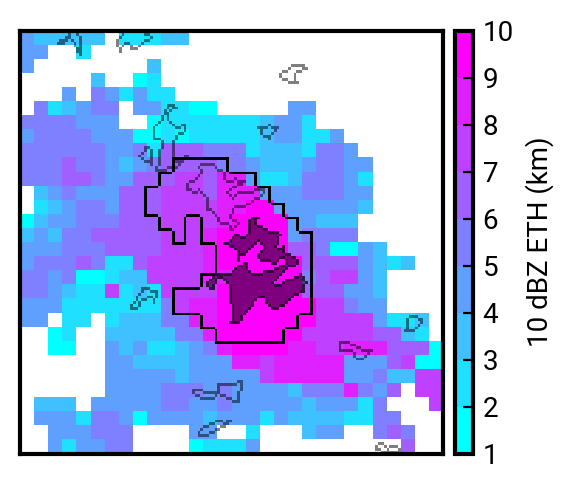

In [35]:
fig = plt.figure(figsize=(3,3))
axs = plt.gca()

cmap = plt.get_cmap('cool')
cmap2 = mcolors.ListedColormap(['black'])
levels = np.arange(1,11,1)
nf = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

Zm0 = np.ma.masked_where(dmax == 0, dmax)
cf1 = plt.pcolormesh(Zm0[y1:y2,x1:x2],norm=nf, cmap=cmap, zorder=2)

tn1 = plt.pcolormesh(Zm1,cmap=cmap2,zorder=4,alpha=.5) # contour perimeters
tn3 = plt.pcolormesh(Zm3,cmap=cmap2,zorder=5,alpha=0.5) # contour perimeters
tn1 = plt.pcolormesh(Tn[y1:y2,x1:x2], cmap=mcolors.ListedColormap(['black']), zorder=3)

axs.set_aspect('equal')
fig.subplots_adjust(right=0.83)

p1 = axs.get_position().y0
h1 = axs.get_position().y1-p1
cbar_ax = fig.add_axes([0.85, p1, 0.03, h1])
cbar = fig.colorbar(cf1, cax=cbar_ax, label='10 dBZ ETH (km)')
cbar.outline.set_linewidth(1.5) 
cbar.ax.tick_params(direction='in')

for spine in axs.spines.values():
    spine.set_linewidth(1.5)

axs.set_xticks([])
axs.set_yticks([])
plt.savefig('/ccsopen/home/enochjo/Paper_Plots/Figure4.png',dpi=300,bbox_inches='tight')